In [109]:
import json
import math
import random
import time
from math import *

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_circles
from tabulate import tabulate

from kdtreen import *
from utils import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [110]:
savefile = "mst_datatest.json"
to_plot = False
no_points = 5
no_centres = 4

In [111]:
if no_points > 999:
    to_plot = False

In [112]:
X, Y = make_blobs(n_samples=no_points, centers=no_centres)
# points = list(set([(x, y) for x, y in X]))
points = list(set([(round(x, 1), round(y, 1)) for x, y in X]))
print(len(points))

5


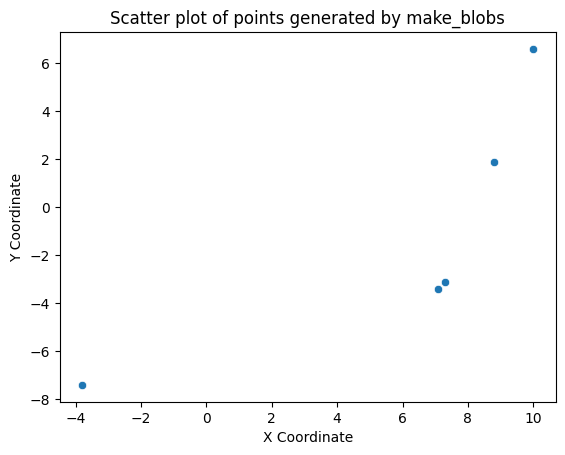

In [113]:
plot_points_x = [point[0] for point in points]
plot_points_y = [point[1] for point in points]

# Use Seaborn to plot
sns.scatterplot(x=plot_points_x, y=plot_points_y)
plt.title("Scatter plot of points generated by make_blobs")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

In [114]:
dcran_start_time = time.time()
i_neighbors_dict = {}
tree = KDTree()
G = nx.Graph()

In [115]:
cordmap = {p: i for i, p in enumerate(points)}
print(cordmap)
print(points)

{(7.1, -3.4): 0, (8.8, 1.9): 1, (7.3, -3.1): 2, (10.0, 6.6): 3, (-3.8, -7.4): 4}
[(7.1, -3.4), (8.8, 1.9), (7.3, -3.1), (10.0, 6.6), (-3.8, -7.4)]


In [116]:
def build(points):
    global cordmap, i_neighbors_dict, tree, G
    cordmap = {p : i for i, p in enumerate(points)}
    print(points)
    tree.root = tree.build(points)
    limit_dist = math.ceil(log(len(points)))

    G.add_nodes_from(cordmap.values())
    for point in points:
        i_neighbors_dict[point] = i_neighbors(tree, point, limit_dist)
    print("max dis : " ,limit_dist )
    return tree, G

In [117]:
for i , point in enumerate(points):
    print(i, point , cordmap[point]) 

0 (7.1, -3.4) 0
1 (8.8, 1.9) 1
2 (7.3, -3.1) 2
3 (10.0, 6.6) 3
4 (-3.8, -7.4) 4


In [118]:
cord2 = {}

In [119]:
cord3 = {p: i for i, p in enumerate(points)}
for i , point in  enumerate(points):
    cord2[point] = i
    print(i, point , cordmap[point] , cord2[point] , cord3[point])

0 (7.1, -3.4) 0 0 0
1 (8.8, 1.9) 1 1 1
2 (7.3, -3.1) 2 2 2
3 (10.0, 6.6) 3 3 3
4 (-3.8, -7.4) 4 4 4


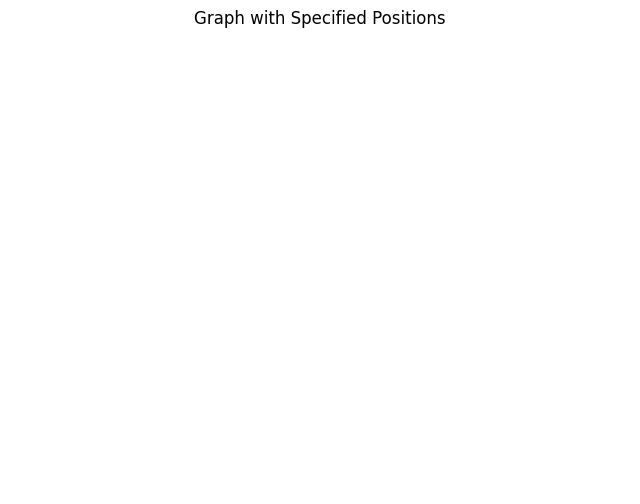

In [120]:
plt.figure(figsize=(8, 6))
cordmap = {i : p for i, p in enumerate(points)}
pos = cordmap  # Use cordmap for positions
nx.draw_networkx_nodes(G, pos=pos, node_size=700, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(G, pos=pos)
plt.title("Graph with Specified Positions")
plt.axis("off")  # Turn off the axis for a cleaner look
plt.show()

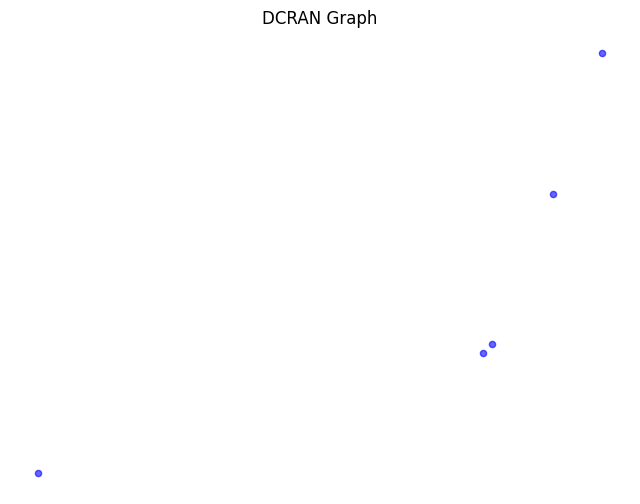

In [121]:
# def plot_graph(G, points):
# Assuming 'points' is a list of coordinates corresponding to the nodes in 'G'
# Create a position map from node index to its coordinates
G.add_nodes_from(cordmap.keys()) 
# Draw the graph
plt.figure(figsize=(8, 6))
pos = cordmap
nx.draw_networkx_nodes(G,pos=pos ,  node_size=20, node_color="blue", alpha=0.6)
nx.draw_networkx_edges(G, pos = pos , alpha=0.4)
plt.title("DCRAN Graph")
plt.axis("off")  # Turn off the axis
plt.show()

In [122]:
print(points)

[(7.1, -3.4), (8.8, 1.9), (7.3, -3.1), (10.0, 6.6), (-3.8, -7.4)]


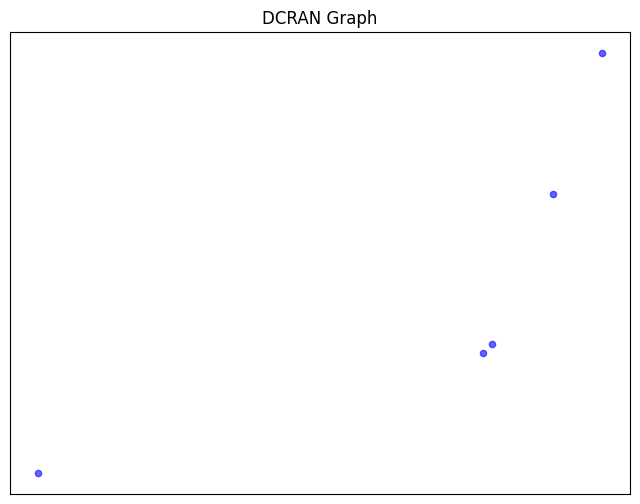

In [123]:
plt.figure(figsize=(8, 6))
    # Generate positions dictionary for networkx from cordmap
pos = {i: points[i] for i in range(len(cordmap))}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue", alpha=0.6)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)
# Optionally, draw node labels or edge weights
# nx.draw_networkx_labels(G, pos)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("DCRAN Graph")
plt.show()

In [124]:
print(G.nodes , points)

[0, 1, 2, 3, 4] [(7.1, -3.4), (8.8, 1.9), (7.3, -3.1), (10.0, 6.6), (-3.8, -7.4)]


In [125]:
def plot_graph(G, cordmap):
    plt.figure(figsize=(8, 6))
    pos = {
        tuple(point): cordmap[tuple(point)] for point in points
    }  # Generate positions from cordmap
    print("pos" , pos)
    # Define a limited set of colors to cycle through
    colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

    # Get connected components
    components = list(nx.connected_components(G))

    # Assign a color to each component by cycling through the defined colors
    for idx, comp in enumerate(components):
        color = colors[idx % len(colors)]  # Cycle through colors with modulo
        nx.draw_networkx_nodes(
            G, pos, nodelist=comp, node_color=color, node_size=20, alpha=0.6
        )
    labels = {i: f"{i}\n{points[i]}" for i in G.nodes()}
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, labels = labels ,  font_size=8, font_color="black")

    # plt.title("DCRAN Graph")
    plt.axis("on")  # Turn off the axis for a cleaner look
    plt.show()

In [126]:
list(nx.connected_components(G))

[{0}, {1}, {2}, {3}, {4}]

In [127]:
i_neighbors_dict

{}

In [128]:
def dcran_1(points):
    global  cordmap , i_neighbors_dict, tree, G
    tree, G = build(points)
    plot_graph(G, cordmap)
    for k in range(math.ceil(log(len(points)))):
        components = list(nx.connected_components(G))
        if len(components) == 1:
            break
        for component in components:
            print("component : ", component)
            for pid in component:
                pointi = points[pid]
                eudis, pointj = i_neighbors_dict[pointi][k]
                if cordmap[pointj] in component:
                    print("skip" , cordmap[pointi], cordmap[pointj] , component)
                    continue
                
                G.add_edge(cordmap[pointi], cordmap[pointj], weight=eudis)
                plot_graph(G, cordmap)
    print(len(list(nx.connected_components(G))))

In [129]:
import math
from math import ceil, log
import networkx as nx


def dcran(points):
    global cordmap, i_neighbors_dict, tree, G
    tree, G = build(
        points
    )  # Make sure this function initializes cordmap and i_neighbors_dict correctly
    plot_graph(G, cordmap)

    for k in range(ceil(log(len(points), 2))):
        components = list(nx.connected_components(G))
        print(f"Iteration {k}, Number of Components: {len(components)}")

        if len(components) == 1:
            break

        for component in components:
            print("Component:", component)
            for pid in component:
                # Ensure we're accessing i_neighbors_dict correctly
                pointi = points[pid]
                if k < len(
                    i_neighbors_dict[pointi]
                ):  # Check if k is within bounds for i_neighbors_dict
                    eudis, pointj = i_neighbors_dict[pointi][k]
                    print(f"Point {pid} : {pointi} has neighbor {cordmap[pointj]}: {pointj} at distance {k}.")

                    # Check if the point is already in the component using indices, not coordinates
                    if cordmap[pointj] in component:
                        print(
                            f"Skipping: Point {pid} to {cordmap[pointj]} within same component."
                        )
                        continue

                    # Add edge based on indices, ensure cordmap[pid] and cordmap[pointj] are used correctly
                    print(f"Adding Edge: {pid} to {cordmap[pointj]} with distance {eudis} , ineb {i_neighbors_dict[pointi] , pointi , k}")
                    G.add_edge(pid, cordmap[pointj], weight=eudis)

                    plot_graph(G, cordmap)
                else:
                    print(f"No neighbor at distance {k} for point {pid}.")

    print(f"Final Number of Components: {len(list(nx.connected_components(G)))}")


# Reminder to define or import your build and plot_graph functions here.

In [130]:
i_neighbors_dict

{}

In [131]:
print(points)
print(cordmap)

[(7.1, -3.4), (8.8, 1.9), (7.3, -3.1), (10.0, 6.6), (-3.8, -7.4)]
{0: (7.1, -3.4), 1: (8.8, 1.9), 2: (7.3, -3.1), 3: (10.0, 6.6), 4: (-3.8, -7.4)}


[(7.1, -3.4), (8.8, 1.9), (7.3, -3.1), (10.0, 6.6), (-3.8, -7.4)]
max dis :  2
pos {(-3.8, -7.4): 4, (7.1, -3.4): 0, (7.3, -3.1): 2, (8.8, 1.9): 1, (10.0, 6.6): 3}


NetworkXError: Node 0 has no position.

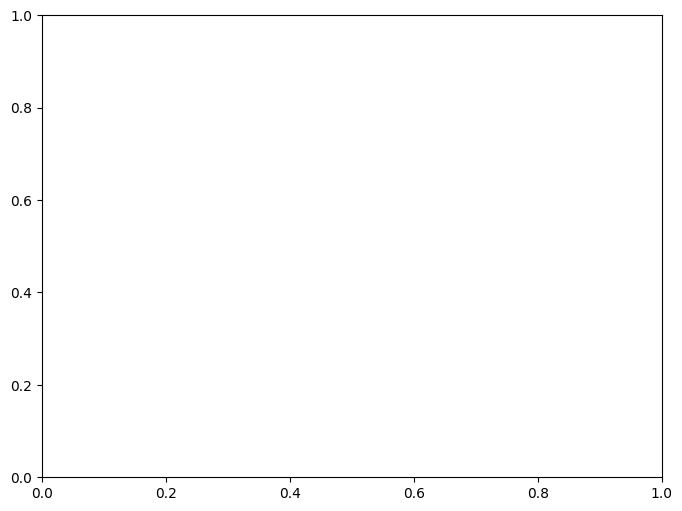

In [132]:
dcran(points)

In [ ]:
cordmap

{(-4.2, 9.2): 0,
 (-7.2, 10.1): 1,
 (-4.0, 2.3): 2,
 (-5.8, 9.2): 3,
 (7.6, -2.8): 4}

In [ ]:
import numpy as np
import networkx as nx

# Assuming cordmap is defined and maps node indices to their coordinates
# Example: cordmap = {0: (1, 2), 1: (2, 3), ...}

centroids = []
components = list(nx.connected_components(G))

for component in components:
    # Fetch the coordinates for each node in the component from cordmap
    component_coords = np.array([points[node] for node in component])
    centroid = component_coords.mean(axis=0)
    centroids.append(centroid)
    print(f"The centroid of the component is {centroid}")

The centroid of the component is [-2.72  5.6 ]


In [ ]:
from scipy.spatial import distance

# Assuming centroids is already defined as shown in previous steps
centroids_x = sorted(enumerate(centroids), key=lambda x: x[1][0])
centroids_y = sorted(enumerate(centroids), key=lambda x: x[1][1])

tot_dis_x = 0
tot_dis_y = 0

for i in range(len(centroids_x) - 1):
    tot_dis_x += distance.euclidean(centroids_x[i][1], centroids_x[i + 1][1])
    tot_dis_y += distance.euclidean(centroids_y[i][1], centroids_y[i + 1][1])

if tot_dis_x > tot_dis_y:
    sorted_indices = [index for index, _ in centroids_y]
else:
    sorted_indices = [index for index, _ in centroids_x]

# sorted_indices will contain the indices of centroids, ordered by the selected sorting criterion

In [ ]:
from scipy.spatial import distance
import numpy as np


def get_closest_points(c1, c2):
    # Convert indices in c1 and c2 to their coordinates using 'points'
    c1_coords = np.array([points[i] for i in c1])
    c2_coords = np.array([points[i] for i in c2])

    # Calculate the centroid of the coordinates in c1
    centroid_c1 = c1_coords.mean(axis=0)

    # Compute the distances from the centroid of c1 to each point in c2
    distances_to_c2 = distance.cdist([centroid_c1], c2_coords)[0]

    # Find the index of the closest point in c2 to the centroid of c1
    min_index_c2 = np.argmin(distances_to_c2)
    p2_index = list(c2)[
        min_index_c2
    ]  # Get the original index of the closest point in c2

    # Compute distances from the closest point in c2 to all points in c1
    distances_to_c1 = distance.cdist([c2_coords[min_index_c2]], c1_coords)[0]

    # Find the index of the closest point in c1 to the closest point in c2
    min_index_c1 = np.argmin(distances_to_c1)
    p1_index = list(c1)[
        min_index_c1
    ]  # Get the original index of the closest point in c1

    # Return the indices of the closest points
    return (p1_index, p2_index)

In [ ]:

for i in range(len(sorted_indices) - 1):
    # Get the components corresponding to the current and next centroid in the sorted list
    component_a = components[sorted_indices[i]]
    component_b = components[sorted_indices[i + 1]]

    # Find the closest points between component_a and component_b
    point_a, point_b = get_closest_points(component_a, component_b)

    # Assuming a function add_edge(point_a, point_b) that adds an edge between two points
    G.add_edge(point_a, point_b)

    print(
        f"Connected component {sorted_indices[i]} to component {sorted_indices[i+1]} through points {point_a} and {point_b}"
    )

pos {0: (-7.2, 10.1), 1: (-5.8, 9.2), 2: (-4.2, 9.2), 3: (-4.0, 2.3), 4: (7.6, -2.8)}


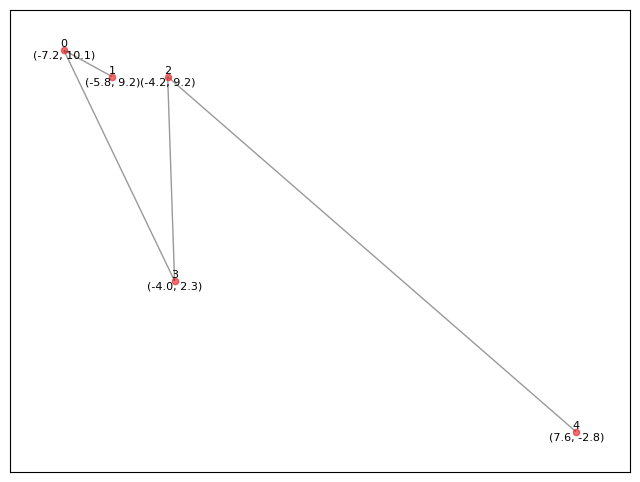

In [ ]:
plot_graph(G, cordmap)

In [ ]:
mst = nx.minimum_spanning_tree(G, algorithm="prim", weight="weight")

pos {0: (-7.2, 10.1), 1: (-5.8, 9.2), 2: (-4.2, 9.2), 3: (-4.0, 2.3), 4: (7.6, -2.8)}


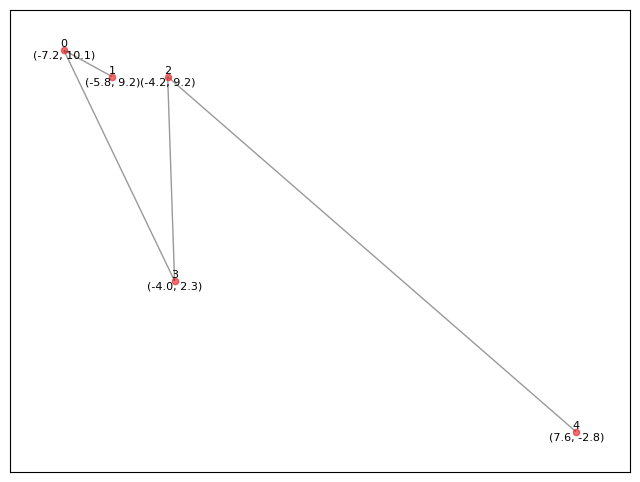

In [ ]:
plot_graph(mst, cordmap)

In [ ]:
dcran_end_time = time.time()
dcran_elapsed_time = dcran_end_time - dcran_start_time
print(dcran_elapsed_time)

2.238138437271118


In [ ]:
stmst_start_time = time.time()

In [ ]:



def calculate_distance(point1, point2):
    return math.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)


def create_distance_matrix(points):
    n = len(points)
    distance_matrix = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            distance = calculate_distance(points[i], points[j])
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix


def primMST(graph):
    num_vertices = len(graph)
    key = [float("inf")] * num_vertices
    parent = [-1] * num_vertices
    mstSet = [False] * num_vertices
    key[0] = 0

    for cout in range(num_vertices):
        u = minKey(key, mstSet)
        mstSet[u] = True
        for v in range(num_vertices):
            if 0 < graph[u][v] < key[v] and mstSet[v] is False:
                key[v] = graph[u][v]
                parent[v] = u
    return parent


def minKey(key, mstSet):
    min = float("inf")
    min_index = -1
    for v in range(len(key)):
        if key[v] < min and not mstSet[v]:
            min, min_index = key[v], v
    return min_index


# Example list of points

# Create the distance matrix
distance_matrix = create_distance_matrix(points)

# Generate MST using Prim's algorithm
mst = primMST(distance_matrix)

# Print the edges in the MST


In [ ]:
stmst_end_time = time.time()
stmst_elapsed_time = stmst_end_time - stmst_start_time
print(stmst_elapsed_time)   

0.04052233695983887


In [ ]:
stmst_elapsed_time/dcran_elapsed_time

0.01810537555900532